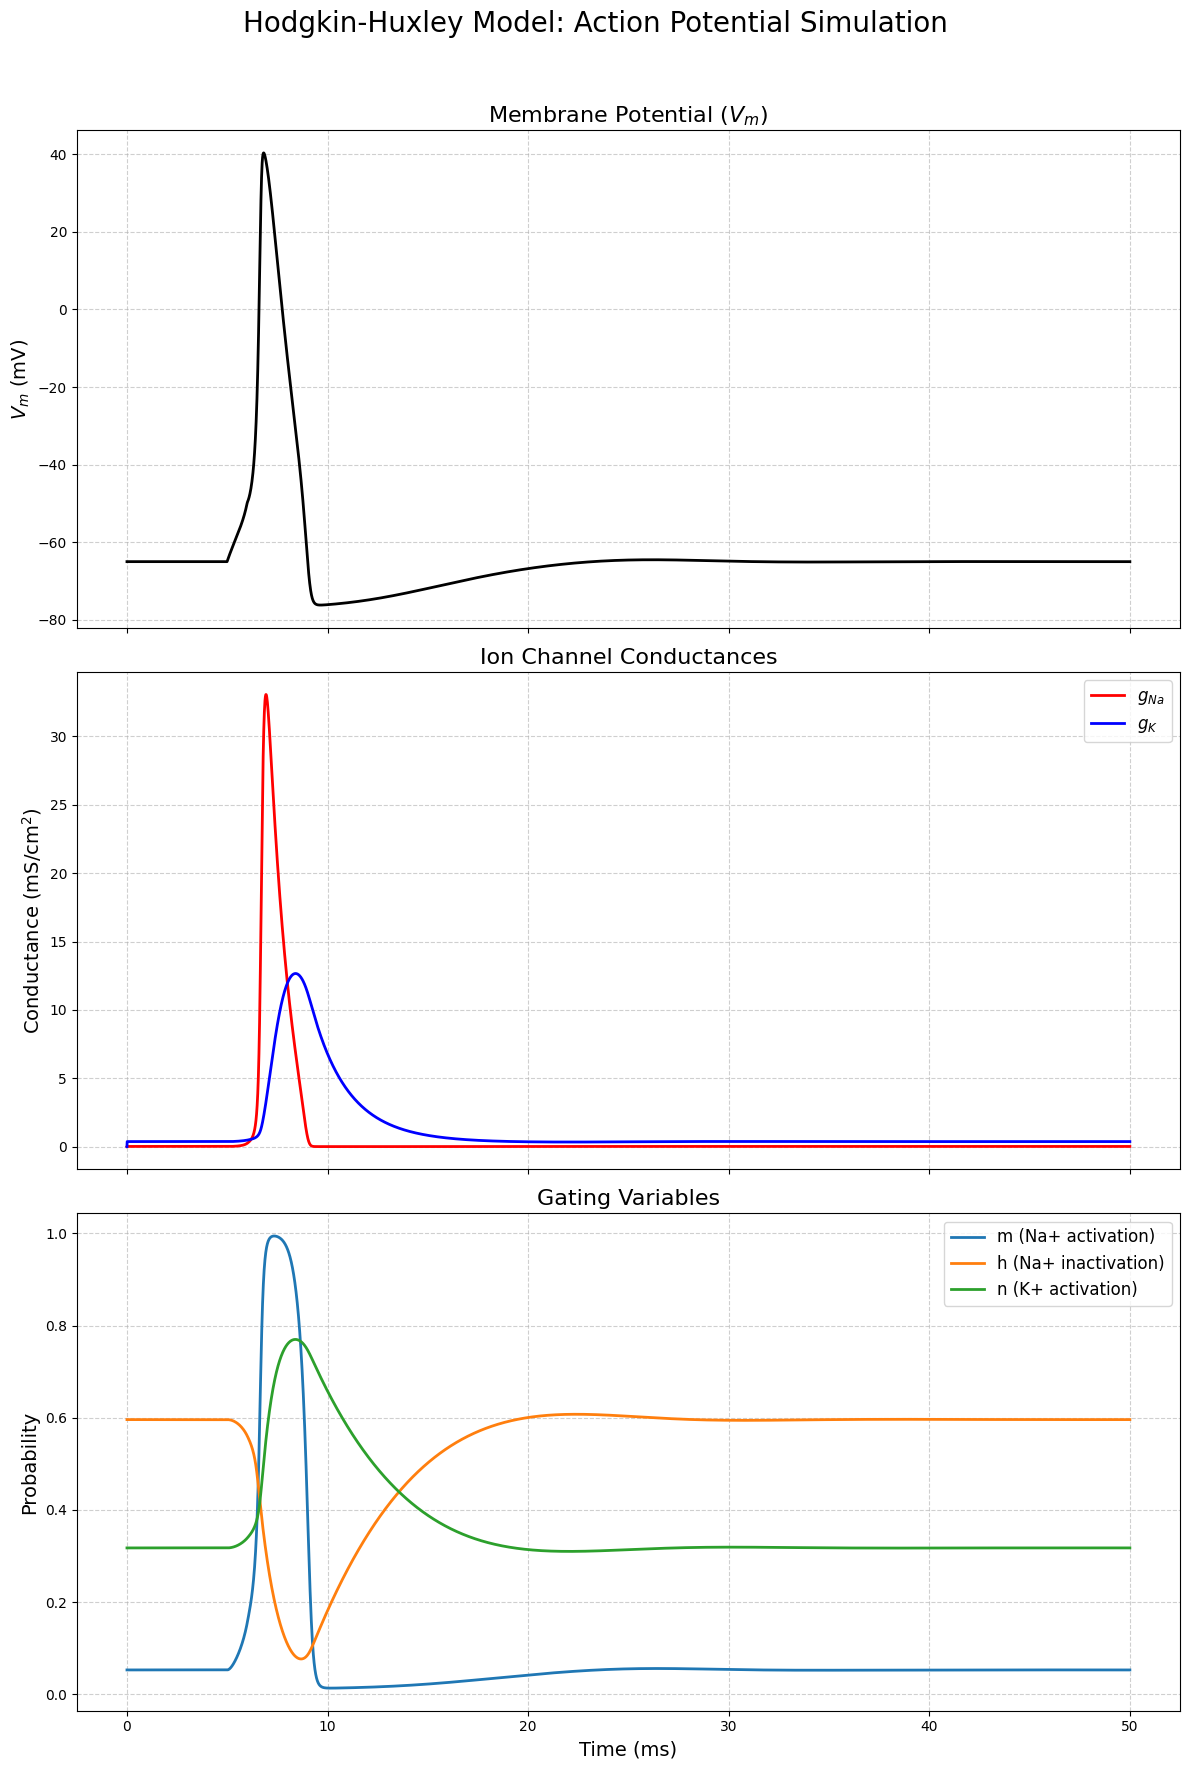

In [1]:
#!/usr/bin/env python3
"""
Interactive Hodgkin-Huxley Action Potential Simulator.

This script integrates the dynamics of sodium (Na+) and potassium (K+) ion
channels to simulate the generation of an action potential in a neuron under
a current-clamp protocol.

The simulation solves the four coupled ordinary differential equations for:
- Vm: Membrane Potential
- m:  Na+ channel activation gate
- h:  Na+ channel inactivation gate
- n:  K+ channel activation gate

It then visualizes the action potential, the underlying changes in ion channel
conductances, and the behavior of the gating variables.
"""

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# 1. Model & Simulation Parameters
# ------------------------------------------------------------------------------
# Membrane Properties
C_m = 1.0      # Membrane capacitance (uF/cm^2)
V_rest = -65.0 # Resting membrane potential (mV)

# Maximum Conductances (mS/cm^2)
gK_max = 36.0
gNa_max = 120.0
g_leak = 0.3

# Reversal Potentials (mV)
E_K = -77.0
E_Na = 50.0
E_leak = -54.4

# Simulation Time
dt = 0.01           # Time step (ms)
tmax = 50.0         # End time of simulation (ms)
t_array = np.arange(0, tmax + dt, dt)

# ------------------------------------------------------------------------------
# 2. Rate Functions for Ion Channel Gates (alpha and beta)
# ------------------------------------------------------------------------------
# Note: These functions depend on the membrane voltage V.

# --- Potassium (K+) Channel Activation Gate 'n' ---
def alpha_n(V):
    """Rate constant alpha_n for K+ activation."""
    if V == -55.0: return 0.1
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    """Rate constant beta_n for K+ activation."""
    return 0.125 * np.exp(-(V + 65.0) / 80.0)

# --- Sodium (Na+) Channel Activation Gate 'm' ---
def alpha_m(V):
    """Rate constant alpha_m for Na+ activation."""
    if V == -40.0: return 1.0
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    """Rate constant beta_m for Na+ activation."""
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

# --- Sodium (Na+) Channel Inactivation Gate 'h' ---
def alpha_h(V):
    """Rate constant alpha_h for Na+ inactivation."""
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    """Rate constant beta_h for Na+ inactivation."""
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

# Vectorize functions for efficiency with numpy arrays
alpha_n_vec, beta_n_vec = np.vectorize(alpha_n), np.vectorize(beta_n)
alpha_m_vec, beta_m_vec = np.vectorize(alpha_m), np.vectorize(beta_m)
alpha_h_vec, beta_h_vec = np.vectorize(alpha_h), np.vectorize(beta_h)

# ------------------------------------------------------------------------------
# 3. Main Simulation Loop
# ------------------------------------------------------------------------------
def run_simulation(I_stim_amplitude=10.0, stim_start=5.0, stim_duration=1.0):
    """
    Runs the Hodgkin-Huxley simulation with a given stimulus current.
    """
    # --- Initialization ---
    # Initialize arrays to store results
    Vm_t = np.zeros_like(t_array)
    gNa_t = np.zeros_like(t_array)
    gK_t = np.zeros_like(t_array)
    m_t = np.zeros_like(t_array)
    h_t = np.zeros_like(t_array)
    n_t = np.zeros_like(t_array)

    # Set initial conditions at resting potential
    Vm_t[0] = V_rest
    m_t[0] = alpha_m(V_rest) / (alpha_m(V_rest) + beta_m(V_rest))
    h_t[0] = alpha_h(V_rest) / (alpha_h(V_rest) + beta_h(V_rest))
    n_t[0] = alpha_n(V_rest) / (alpha_n(V_rest) + beta_n(V_rest))

    # --- Numerical Integration (Euler Method) ---
    for i in range(1, len(t_array)):
        t = t_array[i]
        Vm = Vm_t[i-1]
        m, h, n = m_t[i-1], h_t[i-1], n_t[i-1]

        # Calculate ionic conductances
        gNa = gNa_max * (m**3) * h
        gK = gK_max * (n**4)
        gNa_t[i], gK_t[i] = gNa, gK

        # Calculate ionic currents
        I_Na = gNa * (Vm - E_Na)
        I_K = gK * (Vm - E_K)
        I_leak = g_leak * (Vm - E_leak)
        I_ion = I_Na + I_K + I_leak

        # Apply stimulus current
        I_stim = I_stim_amplitude if stim_start <= t <= stim_start + stim_duration else 0.0

        # Update membrane potential (dV/dt)
        dVm_dt = (I_stim - I_ion) / C_m
        Vm_t[i] = Vm + dVm_dt * dt

        # Update gating variables (dm/dt, dh/dt, dn/dt)
        dm_dt = alpha_m(Vm) * (1 - m) - beta_m(Vm) * m
        dh_dt = alpha_h(Vm) * (1 - h) - beta_h(Vm) * h
        dn_dt = alpha_n(Vm) * (1 - n) - beta_n(Vm) * n
        m_t[i] = m + dm_dt * dt
        h_t[i] = h + dh_dt * dt
        n_t[i] = n + dn_dt * dt

    return Vm_t, gNa_t, gK_t, m_t, h_t, n_t

# ------------------------------------------------------------------------------
# 4. Run the Simulation and Plot Results
# ------------------------------------------------------------------------------
if __name__ == '__main__':
    # Run the simulation with default stimulus
    Vm, gNa, gK, m, h, n = run_simulation(I_stim_amplitude=15.0)

    # --- Create Plots ---
    fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
    fig.suptitle('Hodgkin-Huxley Model: Action Potential Simulation', fontsize=20)

    # Plot 1: Membrane Potential (Action Potential)
    axes[0].plot(t_array, Vm, 'k', linewidth=2)
    axes[0].set_title('Membrane Potential ($V_m$)', fontsize=16)
    axes[0].set_ylabel('$V_m$ (mV)', fontsize=14)
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Plot 2: Ion Channel Conductances
    axes[1].plot(t_array, gNa, 'r-', label='$g_{Na}$', linewidth=2)
    axes[1].plot(t_array, gK, 'b-', label='$g_K$', linewidth=2)
    axes[1].set_title('Ion Channel Conductances', fontsize=16)
    axes[1].set_ylabel('Conductance (mS/cm$^2$)', fontsize=14)
    axes[1].legend(fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.6)

    # Plot 3: Gating Variables
    axes[2].plot(t_array, m, label='m (Na+ activation)', linewidth=2)
    axes[2].plot(t_array, h, label='h (Na+ inactivation)', linewidth=2)
    axes[2].plot(t_array, n, label='n (K+ activation)', linewidth=2)
    axes[2].set_title('Gating Variables', fontsize=16)
    axes[2].set_ylabel('Probability', fontsize=14)
    axes[2].set_xlabel('Time (ms)', fontsize=14)
    axes[2].legend(fontsize=12)
    axes[2].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
